<a href="https://colab.research.google.com/github/harnalashok/deeplearning/blob/main/proper_face_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Call libraries
#%reset -f

# 1.1 Application (ResNet50) library
# https://keras.io/applications/#resnet50
from tensorflow.keras.applications import ResNet50

# 1.2 Keras models and layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense,  GlobalAveragePooling2D

# 1.3 Image generator and preprocessing
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1.4 To save model-weights with least val_acc
#      Refer Page 250 Chollet

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import callbacks

# 1.5 Out optimizer
from tensorflow.keras.optimizers import SGD

# 1.4 Misc
import matplotlib.pyplot as plt
import time,os
import numpy as np


In [2]:
path = "/content"
os.chdir(path)

In [ ]:
!unzip mask.zip

In [4]:
######################### Define necessary constants

# 2. Constants & Modeling
num_classes = 2
image_size = 224      # Restrict image-sizes to uniform: 224 X 224
                      # Decreasing increases speed but reduces accuracy

# 2.1 Image data folders
train_dir= '/content/mask/train'
val_dir = '/content/mask/val'



In [5]:
# 2.2 Create ResNet59 model and import weights
resnet_base_model = ResNet50(
                          include_top=False,   # No last softmax layer
                          pooling='avg',       # GlobalAveragePooling2D to flatten last convolution layer
                                               # See: http://203.122.28.230/moodle/mod/resource/view.php?id=3740
                          weights='imagenet'
                          )


94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
# 2.3 Look at the model
resnet_base_model.summary()

In [6]:
# 2.6 Initialise: Freeze all layers from training
for layer in resnet_base_model.layers:
    layer.trainable = False


In [7]:
# 2.7 Make layer 161 onwards available for training
#     Re-training some ResNet layers without sufficient data
#      may reduce speed as also accuracy

for layer in resnet_base_model.layers[160:]:
    layer.trainable = True


In [8]:
########### Add classification layers #############

# 3 Start nested model building
my_new_model = Sequential()


# 3.1 Nest base model within it
my_new_model.add(resnet_base_model)


# 3.2
my_new_model.summary()

# 3.3 Last output softmax layer
my_new_model.add(Dense(
                       num_classes,
                       activation='softmax'
                       )
                )


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
Total params: 23,587,712
Trainable params: 5,520,384
Non-trainable params: 18,067,328
_________________________________________________________________


In [9]:
# 4.0 Compile model
#     Define our optimizer
optimize = SGD(lr = 0.01, nesterov = True)     # Default nestrov = True
my_new_model.compile(
                     optimizer= optimize,              # 'sgd'; One record at a time. It is fast
                     loss='categorical_crossentropy',  # Same as binary-crossentropy
                                                       # Used when labels are one-hot-encoded
                     metrics=['accuracy']
                     )



In [10]:

# 4.1 Image processing and image generation
#     train data Image generator object
data_generator_with_aug = ImageDataGenerator(
                                             preprocessing_function=preprocess_input,      # keras image preprocessing function
                                             horizontal_flip=True,
                                             width_shift_range = 0.2,
                                             height_shift_range = 0.2
                                            )


In [11]:
# 4.2 No fit() needed
#     Create image data generator interator for train data
train_generator = data_generator_with_aug.flow_from_directory(
                                                              train_dir,
                                                              target_size=(image_size, image_size),
                                                              batch_size=16 ,    # Increasing it increases
                                                                                 # processing time & may decrease accu
                                                              class_mode='categorical'  # labels are in OHE format
                                                              )


Found 199 images belonging to 2 classes.


In [12]:
# 4.3 validation data generator object
#     We will manipulate even Validation data also
#     Just to see if predictions are still made correctly
#     'data_generator_no_aug' is learner + ImageDataGenerator object
data_generator_no_aug = ImageDataGenerator(
                                           preprocessing_function=preprocess_input,
                                           rotation_range=90,
                                           horizontal_flip=True,
                                           vertical_flip=True,
                                           )



In [13]:
# 4.4 validation data image iterator
validation_generator = data_generator_no_aug.flow_from_directory(
                                                                 val_dir,
                                                                 target_size=(image_size, image_size),
                                                                 batch_size= 16,
                                                                 class_mode='categorical'
                                                                 )



Found 27 images belonging to 2 classes.


In [14]:

# 5. Prepare a list of callback functions
#    We will only have one. It will look at the val_loss
#    at the end of each epoch. Only if val_loss, for current
#    epoch is less than the previous, model-weights will be
#    saved, else not.
#    Refer page 250 Chollet

# 5.01
checkpoint_path = '/content/'
filepath =  checkpoint_path + "my_model.h5"


In [15]:
# 5.02 Delete any existing file. Linux command
if os.path.exists(checkpoint_path):
    os.system('rm ' + filepath)


In [16]:

# 5.04 Check if "my_model.h5" exists?
os.path.exists(filepath)     # False


False

In [17]:

# 5.1 Create now callbacks list:
mycallbacks_list = [
                     ModelCheckpoint(filepath= filepath,
                                    monitor = 'val_loss',
                                    save_best_only = True
                                    ),
                    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau
                    ReduceLROnPlateau( monitor='val_loss',
                                      factor = 0.5,          # Reduce lr by a factor of 0.5
                                      patience = 5           # If best val loss does not improve
                                                             #  for five consecutive epochs
                                      )
                    ]


In [18]:

start = time.time()
history = my_new_model.fit(
                           train_generator,
                           steps_per_epoch=4,     #  Total number of batches of samples to
                                                  #   yield from generator before declaring one epoch
                                                  #     finished and starting the next epoch.
                                                  #   Increase it to train the model better
                           epochs=15,             # All steps when finished, constitute one epoch
						                         # Increase it to get better training
                           validation_data=validation_generator,
                           validation_steps=2,    #  Total number of steps (batches of samples)
                                                  #   to yield from validation_data generator per epoch
                                                  #    Increase it to get a better idea of validation accu
                           workers = 2,           # Maximum number of processes to spin up
                           callbacks=mycallbacks_list, # What callbacks to act upon after each epoch
                           verbose = 1            # Show progress

                           )

end = time.time()
print("Time taken: ", (end - start)/60, "minutes")


Epoch 1/15
4/4 [==============================] - 17s 4s/step - loss: 0.9161 - accuracy: 0.5021 - val_loss: 0.7343 - val_accuracy: 0.7407
Epoch 2/15
4/4 [==============================] - 13s 3s/step - loss: 1.1080 - accuracy: 0.5083 - val_loss: 0.8269 - val_accuracy: 0.7407
Epoch 3/15
4/4 [==============================] - 13s 3s/step - loss: 0.6460 - accuracy: 0.6792 - val_loss: 1.1973 - val_accuracy: 0.3704
Epoch 4/15
4/4 [==============================] - 13s 3s/step - loss: 0.6628 - accuracy: 0.6917 - val_loss: 0.7253 - val_accuracy: 0.6296
Epoch 5/15
4/4 [==============================] - 13s 3s/step - loss: 0.3279 - accuracy: 0.8333 - val_loss: 1.1173 - val_accuracy: 0.7407
Epoch 6/15
4/4 [==============================] - 14s 3s/step - loss: 0.8198 - accuracy: 0.6271 - val_loss: 0.6180 - val_accuracy: 0.7778
Epoch 7/15
4/4 [==============================] - 13s 3s/step - loss: 0.2737 - accuracy: 0.8729 - val_loss: 0.7110 - val_accuracy: 0.6667
Epoch 8/15
4/4 [==================

In [19]:

# 5.3 So how to begin now?
#     We will begin our work from saved weights
#     Execute all lines upto para 5.01 AND also
#     execute para 5.1. Continue next.

# 5.3.1 Load model weights saved by checkpointing
#       Have a look if model-weights have actually
#       been saved.

os.listdir(checkpoint_path)


['.config', 'my_model.h5', 'mask', 'mask.zip', 'sample_data']

In [20]:

# 5.3.2
my_new_model.load_weights(checkpoint_path + "my_model.h5")


In [21]:

# 5.3.3 Start fitting again. This time validation accuracy starts
#       higher up
start = time.time()
history = my_new_model.fit(
                           train_generator,
                           steps_per_epoch=4,     #  Total number of batches of samples to
                                                  #   yield from generator before declaring one epoch
                                                  #     finished and starting the next epoch.
                                                  #   Increase it to train the model better
                           epochs=10,             # All steps when finished, constitute one epoch
						                         # Increase it to get better training
                           validation_data=validation_generator,
                           validation_steps=2,    #  Total number of steps (batches of samples)
                                                  #   to yield from validation_data generator per epoch
                                                  #    Increase it to get a better idea of validation accu
                           workers = 2,           # Maximum number of processes to spin up
                           callbacks=mycallbacks_list, # What callbacks to act upon after each epoch
                           verbose = 1            # Show progress

                           )

end = time.time()
print("Time taken: ", (end - start)/60, "minutes")



Epoch 1/10
4/4 [==============================] - 12s 3s/step - loss: 0.2124 - accuracy: 0.9455 - val_loss: 1.0506 - val_accuracy: 0.6667
Epoch 2/10
4/4 [==============================] - 13s 3s/step - loss: 0.1102 - accuracy: 0.9531 - val_loss: 0.8205 - val_accuracy: 0.7778
Epoch 3/10
4/4 [==============================] - 12s 3s/step - loss: 0.1672 - accuracy: 0.9455 - val_loss: 0.9772 - val_accuracy: 0.7407
Epoch 4/10
4/4 [==============================] - 13s 3s/step - loss: 0.0688 - accuracy: 1.0000 - val_loss: 0.9481 - val_accuracy: 0.7778
Epoch 5/10
4/4 [==============================] - 13s 3s/step - loss: 0.1007 - accuracy: 0.9844 - val_loss: 0.5137 - val_accuracy: 0.8519
Epoch 6/10
4/4 [==============================] - 13s 3s/step - loss: 0.0712 - accuracy: 0.9844 - val_loss: 0.8376 - val_accuracy: 0.7778
Epoch 7/10
4/4 [==============================] - 13s 3s/step - loss: 0.0608 - accuracy: 1.0000 - val_loss: 0.3919 - val_accuracy: 0.8519
Epoch 8/10
4/4 [==================

In [22]:

# 5.4
#     How accuracy changes as epochs increase
#     We will use this function agai and again
#     in subsequent examples

def plot_history():
    val_acc = history.history['val_accuracy']
    tr_acc=history.history['accuracy']
    epochs = range(1, len(val_acc) +1)
    plt.plot(epochs,val_acc, 'b', label = "Validation accu")
    plt.plot(epochs, tr_acc, 'r', label = "Training accu")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.show()


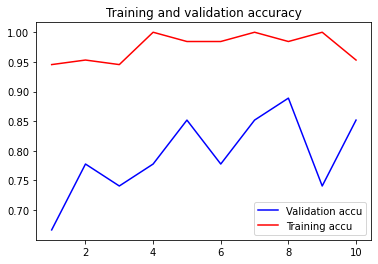

In [23]:

# 5.4 Plot training accuracy and validation accuracy
#     Next time use TensorBoard
plot_history()


In [ ]:
################ I am done ##################33